# Импорт библиотек

In [38]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [2]:
df = pd.read_csv("history.csv", nrows=int(1e5))
df = df[~df.Symbol.isin((df[df["Close"] == 0].Symbol).unique())]

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,2008-01-29,9.50,9.99,8.57,8.75,0.702589,1489000,AACG
1,2008-01-30,8.75,9.15,8.30,8.50,0.682516,219000,AACG
2,2008-01-31,8.49,10.30,8.49,9.55,0.766826,182300,AACG
3,2008-02-01,9.93,9.94,9.50,9.51,0.763614,28200,AACG
4,2008-02-04,9.50,9.71,9.50,9.50,0.762811,8300,AACG
...,...,...,...,...,...,...,...,...
99995,2021-04-15,40.00,41.00,37.50,37.50,37.500000,50092,ABEO
99996,2021-04-16,37.50,38.00,35.75,37.25,37.250000,63172,ABEO
99997,2021-04-19,36.50,37.25,34.00,35.25,35.250000,47496,ABEO
99998,2021-04-20,34.25,37.00,34.00,36.50,36.500000,38796,ABEO


# Обработка данных
1) Нужно разделить данные ПО ВРЕМЕНИ на train-test
2) Каждый sample - это фичи по акции за год и таргет на следующий год

In [4]:
import pandas as pd
import numpy as np


def preprocess_stock_data_with_n_years(df, n_years=3, test_split_year=2022):
    """
    Preprocess stock data to create samples with N years of historical data

    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing stock data
    n_years : int, default=3
        Number of years to include in each sample (N-1 previous years + current year)
    test_split_year : int, default=2022
        Year to split train/test data (data before this year = train, from this year = test)

    Returns:
    --------
    train_df : pandas.DataFrame
        Training dataset with N-year sequences
    test_df : pandas.DataFrame
        Testing dataset with N-year sequences
    feature_columns : list
        List of feature column names for the N-year windows
    """

    # Convert Date to datetime and extract year
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df["Date"].dt.year

    # Sort by Symbol and Date to ensure chronological order
    df = df.sort_values(["Symbol", "Date"])

    # Function to calculate yearly features for each symbol
    def calculate_yearly_features(group):
        """
        Calculate price change, std price for each year
        """
        # Get first and last trading days of the year
        first_price = group["Adj Close"].iloc[0]
        last_price = group["Adj Close"].iloc[-1]

        # Calculate price change for the year (as percentage)
        price_change = (last_price - first_price) / first_price

        # Calculate standard deviation of prices during the year (normalized)
        std_price = group["Adj Close"].std() / first_price

        return pd.Series(
            {
                "price_change": price_change,
                "std_price": std_price,
                "first_price": first_price,
                "last_price": last_price,
            }
        )

    # Group by Symbol and Year and apply calculations
    yearly_data = (
        df.groupby(["Symbol", "Year"]).apply(calculate_yearly_features).reset_index()
    )

    # Create target variables: price_change_of_future_year and price_std_of_future_year
    yearly_data["price_change_of_future_year"] = yearly_data.groupby("Symbol")[
        "price_change"
    ].shift(-1)
    yearly_data["price_std_of_future_year"] = yearly_data.groupby("Symbol")[
        "std_price"
    ].shift(-1)

    # Drop rows where we don't have future year data (last year for each symbol)
    yearly_data = yearly_data.dropna(
        subset=["price_change_of_future_year", "price_std_of_future_year"]
    )

    # Sort by Symbol and Year
    yearly_data = yearly_data.sort_values(["Symbol", "Year"])

    # Create samples with N years of historical data
    samples = []

    # Group by Symbol to process each symbol separately
    for symbol, symbol_group in yearly_data.groupby("Symbol"):
        # Make sure the data is sorted by year
        symbol_group = symbol_group.sort_values("Year")

        # Create rolling windows of N years
        for i in range(len(symbol_group) - n_years):
            # Get the window of N years (current + N-1 previous years)
            window = symbol_group.iloc[i : i + n_years]

            # Get the target year (the year after the current window)
            target_row = symbol_group.iloc[i + n_years]

            # Create a sample dictionary
            sample = {
                "Symbol": symbol,
                "current_year": window["Year"].iloc[-1],  # Last year in the window
                "target_year": target_row["Year"],
                "price_change_of_future_year": target_row[
                    "price_change_of_future_year"
                ],
                "price_std_of_future_year": target_row["price_std_of_future_year"],
            }

            # Add features for each year in the window
            for j, (_, year_row) in enumerate(window.iterrows()):
                year_offset = -(n_years - 1 - j)  # -2, -1, 0 for n_years=3
                sample[f"price_change_year_{year_offset}"] = year_row["price_change"]
                sample[f"std_price_year_{year_offset}"] = year_row["std_price"]

            samples.append(sample)

    # Create DataFrame from samples
    n_year_df = pd.DataFrame(samples)

    # Create feature columns list (excluding metadata and target columns)
    feature_columns = [
        col
        for col in n_year_df.columns
        if col
        not in [
            "Symbol",
            "current_year",
            "target_year",
            "price_change_of_future_year",
            "price_std_of_future_year",
        ]
    ]

    # Chronological train-test split based on current_year
    train_mask = n_year_df["current_year"] < test_split_year
    test_mask = n_year_df["current_year"] >= test_split_year

    train_df = n_year_df[train_mask].copy()
    test_df = n_year_df[test_mask].copy()

    # Display shapes and sample data
    print(f"Original yearly data shape: {yearly_data.shape}")
    print(f"N-year sequences dataset shape: {n_year_df.shape}")
    print(f"Train dataset shape: {train_df.shape}")
    print(f"Test dataset shape: {test_df.shape}")
    print(f"\nSample of N-year sequences dataset (N={n_years}):")
    print(n_year_df.head(5))

    print(f"\nFeature columns for N={n_years} years:")
    print(feature_columns)

    print("\nData preprocessing complete!")
    print(f"Available symbols: {n_year_df['Symbol'].nunique()}")
    print(
        f"Current year range: {n_year_df['current_year'].min()} - {n_year_df['current_year'].max()}"
    )
    print(
        f"Target year range: {n_year_df['target_year'].min()} - {n_year_df['target_year'].max()}"
    )

    return train_df, test_df, feature_columns


N_YEARS = 5  # Number of years to include (2 previous + current)
TEST_SPLIT_YEAR = 2022

# Run preprocessing
train_df, test_df, feature_columns = preprocess_stock_data_with_n_years(
    df=df, n_years=N_YEARS, test_split_year=TEST_SPLIT_YEAR
)

# # Save processed data
# train_df.to_csv(f'train_data_n{N_YEARS}.csv', index=False)
# test_df.to_csv(f'test_data_n{N_YEARS}.csv', index=False)

Original yearly data shape: (397, 8)
N-year sequences dataset shape: (305, 15)
Train dataset shape: (291, 15)
Test dataset shape: (14, 15)

Sample of N-year sequences dataset (N=5):
  Symbol  current_year  target_year  price_change_of_future_year  \
0     AA          1982         1983                    -0.140307   
1     AA          1983         1984                     0.091712   
2     AA          1984         1985                    -0.089242   
3     AA          1985         1986                     0.361201   
4     AA          1986         1987                     0.142124   

   price_std_of_future_year  price_change_year_-4  std_price_year_-4  \
0                  0.081844              0.086581           0.079315   
1                  0.063682              0.226800           0.058640   
2                  0.079152              0.135682           0.112251   
3                  0.221881             -0.109682           0.115252   
4                  0.095589              0.276305

In [5]:
# del df

# Тестируем baseline
Изменение цены в этом году отражает динамику следующего года

In [6]:
from sklearn.metrics import r2_score

y_pred = train_df["price_change_year_0"].values
y_true = train_df["price_change_of_future_year"].values

mean_perc_error = r2_score(y_true=y_true, y_pred=y_pred)
mean_perc_error

-9.192802750522452

In [7]:
y_pred = train_df["std_price_year_0"].values
y_true = train_df["price_std_of_future_year"].values

mean_perc_error = r2_score(y_true=y_true, y_pred=y_pred)
mean_perc_error

-2.3852160288430126

# Улучшение №0: Линейная регрессия

In [8]:
train_df

,Symbol,current_year,target_year,price_change_of_future_year,price_std_of_future_year,price_change_year_-4,std_price_year_-4,price_change_year_-3,std_price_year_-3,price_change_year_-2,std_price_year_-2,price_change_year_-1,std_price_year_-1,price_change_year_0,std_price_year_0
0,AA,1982,1983,-0.140307,0.081844,0.086581,0.079315,0.226800,0.058640,0.135682,0.112251,-0.109682,0.115252,0.276305,0.114729
1,AA,1983,1984,0.091712,0.063682,0.226800,0.058640,0.135682,0.112251,-0.109682,0.115252,0.276305,0.114729,0.566627,0.189272
2,AA,1984,1985,-0.089242,0.079152,0.135682,0.112251,-0.109682,0.115252,0.276305,0.114729,0.566627,0.189272,-0.140307,0.081844
3,AA,1985,1986,0.361201,0.221881,-0.109682,0.115252,0.276305,0.114729,0.566627,0.189272,-0.140307,0.081844,0.091712,0.063682
4,AA,1986,1987,0.142124,0.095589,0.276305,0.114729,0.566627,0.189272,-0.140307,0.081844,0.091712,0.063682,-0.089242,0.079152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,ABEO,2015,2016,2.170000,0.995428,-0.417004,0.140936,-0.828571,0.281341,-0.074074,0.325086,-0.724000,0.474185,-0.011765,0.477244
301,ABEO,2016,2017,-0.584884,0.204113,-0.828571,0.281341,-0.074074,0.325086,-0.724000,0.474185,-0.011765,0.477244,0.418129,0.493629
302,ABEO,2017,2018,-0.534851,0.311994,-0.074074,0.325086,-0.724000,0.474185,-0.011765,0.477244,0.418129,0.493629,2.170000,0.995428
303,ABEO,2018,2019,-0.510903,0.227573,-0.724000,0.474185,-0.011765,0.477244,0.418129,0.493629,2.170000,0.995428,-0.584884,0.204113


In [9]:
X = train_df[[col for col in train_df.columns if "price_change_year_" in col]].values
y_true = train_df["price_change_of_future_year"].values

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=False).fit(X, y_true)
y_pred = model.predict(X)
mean_perc_error = r2_score(y_true=y_true, y_pred=y_pred)
mean_perc_error

-0.017741260940908887

In [11]:
model.coef_

array([ 0.17049087, -0.08219103,  0.07094473,  0.00150179, -0.02204093])

In [12]:
np.mean(np.abs(y_pred))

0.08780719784551796

Видим, что модель обучается предсказывать числа близкие к нулю вопреки ожиданиям. Это значит, что одни лишь данные динамики изменения цен за предыдущие года имеют низкую предсказательную способность. Попробуем брать более точную динамику (по месяцам).

In [43]:
import pandas as pd
import numpy as np


def preprocess_monthly_stock_data(
    df, n_months=6, m_months=3, test_split_date="2022-01-01"
):
    """
    Preprocess stock data at monthly granularity to predict cumulative returns over next M months

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing stock data with columns: Date, Open, High, Low, Close, Adj Close, Volume, Symbol
    n_months : int, default=6
        Number of previous months to use as features
    m_months : int, default=3
        Number of future months to predict cumulative returns for
    test_split_date : str, default='2022-01-01'
        Date to split train/test data (format: 'YYYY-MM-DD')

    Returns:
    --------
    train_df : pandas.DataFrame
        Training dataset
    test_df : pandas.DataFrame
        Testing dataset
    feature_columns : list
        List of feature column names
    target_column : str
        Name of the target column
    """

    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Convert Date to datetime
    df["Date"] = pd.to_datetime(df["Date"])

    # Sort by Symbol and Date to ensure chronological order
    df = df.sort_values(["Symbol", "Date"])

    # Create monthly periods for each row
    df["Month"] = df["Date"].dt.to_period("M")

    # Function to calculate monthly features for each symbol
    def calculate_monthly_features(group):
        """
        Calculate monthly returns and normalized volatility for each month
        """
        # Sort the group by date to ensure proper ordering
        group = group.sort_values("Date")

        # Get first and last trading days of the month
        first_price = group["Adj Close"].iloc[0]
        last_price = group["Adj Close"].iloc[-1]

        # Calculate monthly return (as percentage)
        monthly_return = (last_price - first_price) / first_price

        # Calculate normalized volatility (std of daily returns within month)
        daily_returns = group["Adj Close"].pct_change().dropna()
        monthly_volatility = daily_returns.std() if len(daily_returns) > 1 else 0

        # Calculate monthly volume change
        first_volume = group["Volume"].iloc[0]
        last_volume = group["Volume"].iloc[-1]
        volume_change = (
            (last_volume - first_volume) / first_volume if first_volume != 0 else 0
        )

        # Get the midpoint date of the month for proper time alignment
        midpoint_date = (
            group["Date"].iloc[len(group) // 2]
            if len(group) > 0
            else group["Date"].iloc[0]
        )

        return pd.Series(
            {
                "monthly_return": monthly_return,
                "monthly_volatility": monthly_volatility,
                "volume_change": volume_change,
                "first_price": first_price,
                "last_price": last_price,
                "midpoint_date": midpoint_date,
            }
        )

    # Group by Symbol and Month and apply calculations
    monthly_data = (
        df.groupby(["Symbol", "Month"]).apply(calculate_monthly_features).reset_index()
    )

    # Convert Month period to datetime for easier manipulation
    monthly_data["month_end_date"] = monthly_data["Month"].dt.end_time
    monthly_data["month_start_date"] = monthly_data["Month"].dt.start_time

    # Sort by Symbol and Month
    monthly_data = monthly_data.sort_values(["Symbol", "Month"])

    # Create samples with N months of historical data and M months of future target
    samples = []

    # Group by Symbol to process each symbol separately
    for symbol, symbol_group in monthly_data.groupby("Symbol"):
        # Make sure the data is sorted by month
        symbol_group = symbol_group.sort_values("Month")

        # Create rolling windows - ensure we have enough data for N + M months
        if len(symbol_group) < n_months + m_months:
            continue  # Skip symbols with insufficient data

        for i in range(len(symbol_group) - n_months - m_months + 1):
            # Get the current window of N months (features)
            feature_window = symbol_group.iloc[i : i + n_months]

            # Get the future window of M months (target)
            target_window = symbol_group.iloc[i + n_months : i + n_months + m_months]

            # Calculate cumulative return over the next M months
            # Start from the first price of the first target month
            # End at the last price of the last target month
            start_price = target_window["first_price"].iloc[0]
            end_price = target_window["last_price"].iloc[-1]
            cumulative_return = (
                (end_price - start_price) / start_price if start_price != 0 else 0
            )

            # Create a sample dictionary
            sample = {
                "Symbol": symbol,
                "feature_end_date": feature_window["month_end_date"].iloc[-1],
                "target_start_date": target_window["month_start_date"].iloc[0],
                "target_end_date": target_window["month_end_date"].iloc[-1],
                f"cumulative_return_next_{m_months}_months": cumulative_return,
                "n_months_used": n_months,
                "m_months_predicted": m_months,
            }

            # Add features for each month in the window
            for j, (_, month_row) in enumerate(feature_window.iterrows()):
                month_offset = -(
                    n_months - 1 - j
                )  # -5, -4, -3, -2, -1, 0 for n_months=6

                # Monthly return feature
                sample[f"return_month_{month_offset}"] = month_row["monthly_return"]

                # Monthly volatility feature
                sample[f"volatility_month_{month_offset}"] = month_row[
                    "monthly_volatility"
                ]

                # Volume change feature
                sample[f"volume_change_month_{month_offset}"] = month_row[
                    "volume_change"
                ]

            samples.append(sample)

    if not samples:
        raise ValueError(
            f"No valid samples created. Check if you have enough data for n_months={n_months} and m_months={m_months}"
        )

    # Create DataFrame from samples
    monthly_df = pd.DataFrame(samples)

    # Create feature columns list (excluding metadata and target columns)
    target_column = f"cumulative_return_next_{m_months}_months"
    exclude_columns = [
        "Symbol",
        "feature_end_date",
        "target_start_date",
        "target_end_date",
        target_column,
        "n_months_used",
        "m_months_predicted",
    ]
    feature_columns = [col for col in monthly_df.columns if col not in exclude_columns]

    # Convert test_split_date to datetime
    test_split_datetime = pd.to_datetime(test_split_date)

    # Chronological train-test split based on feature_end_date
    train_mask = monthly_df["feature_end_date"] < test_split_datetime
    test_mask = monthly_df["feature_end_date"] >= test_split_datetime

    train_df = monthly_df[train_mask].copy()
    test_df = monthly_df[test_mask].copy()

    # # Display shapes and sample data
    # print(f"Original monthly data shape: {monthly_data.shape}")
    # print(f"Monthly sequences dataset shape: {monthly_df.shape}")
    # print(f"Train dataset shape: {train_df.shape}")
    # print(f"Test dataset shape: {test_df.shape}")
    # print(f"\nSample of monthly sequences dataset (N={n_months} months, M={m_months} months):")
    # print(monthly_df.head(5))

    # print(f"\nFeature columns for N={n_months} months:")
    # print(feature_columns)

    # print(f"\nTarget column: {target_column}")

    # print("\nData preprocessing complete!")
    # print(f"Available symbols: {monthly_df['Symbol'].nunique()}")
    # if not monthly_df.empty:
    #     print(f"Feature end date range: {monthly_df['feature_end_date'].min()} - {monthly_df['feature_end_date'].max()}")
    #     print(f"Target end date range: {monthly_df['target_end_date'].min()} - {monthly_df['target_end_date'].max()}")

    return train_df, test_df, feature_columns, target_column


all_prev_months = list(range(6, 64, 6))
result_scores = []
# Example usage:
if __name__ == "__main__":
    for prev_months in tqdm(all_prev_months):
        train_df, test_df, features, target = preprocess_monthly_stock_data(
            df,  # Your DataFrame here
            n_months=prev_months,
            m_months=12,
            test_split_date="2022-01-01",
        )
        X, y_true = train_df[[f for f in features if "return" in f]], train_df[target]
        model = LinearRegression(fit_intercept=False).fit(X, y_true)
        y_pred = model.predict(X)
        mean_perc_error = r2_score(y_true=y_true, y_pred=y_pred)
        result_scores.append(mean_perc_error)

100%|██████████| 10/10 [01:24<00:00,  8.48s/it]


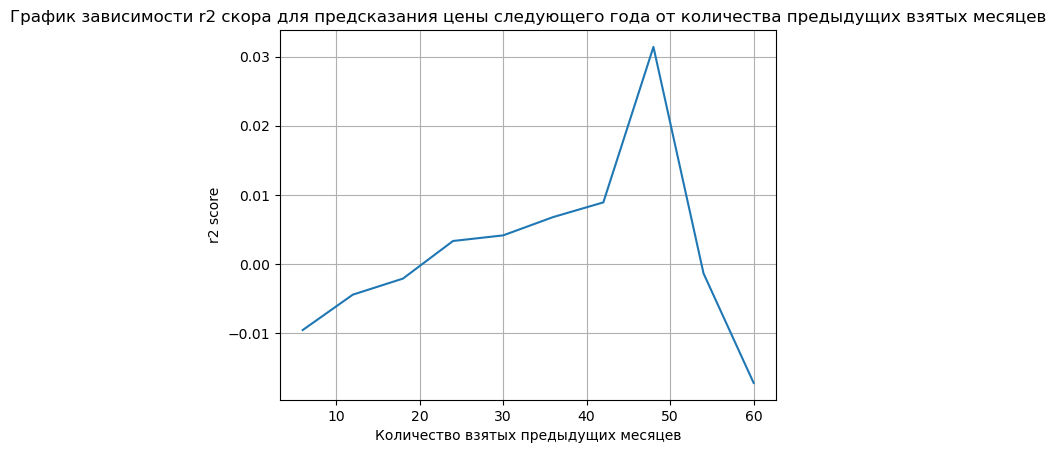

In [45]:
import matplotlib.pyplot as plt

plt.plot(all_prev_months, result_scores)
plt.xlabel("Количество взятых предыдущих месяцев")
plt.ylabel("r2 score")
plt.grid()
plt.title(
    "График зависимости r2 скора для предсказания цены следующего года от количества предыдущих взятых месяцев"
)

Отсюда видно, что график имеет явный пик примерно на 48 месяцах (4 годах). Далее идет на спад. Это может быть связано с уменьшением объема данных при дальнейшем увеличении длины последовательности каждого сэмпла.

In [48]:
all_fut_months = list(range(4, 30, 4))
result_scores = []
# Example usage:
if __name__ == "__main__":
    for fut_months in tqdm(all_fut_months):
        train_df, test_df, features, target = preprocess_monthly_stock_data(
            df,  # Your DataFrame here
            n_months=48,
            m_months=fut_months,
            test_split_date="2022-01-01",
        )
        X, y_true = train_df[[f for f in features if "return" in f]], train_df[target]
        model = LinearRegression(fit_intercept=False).fit(X, y_true)
        y_pred = model.predict(X)
        mean_perc_error = r2_score(y_true=y_true, y_pred=y_pred)
        result_scores.append(mean_perc_error)

100%|██████████| 7/7 [01:02<00:00,  8.98s/it]


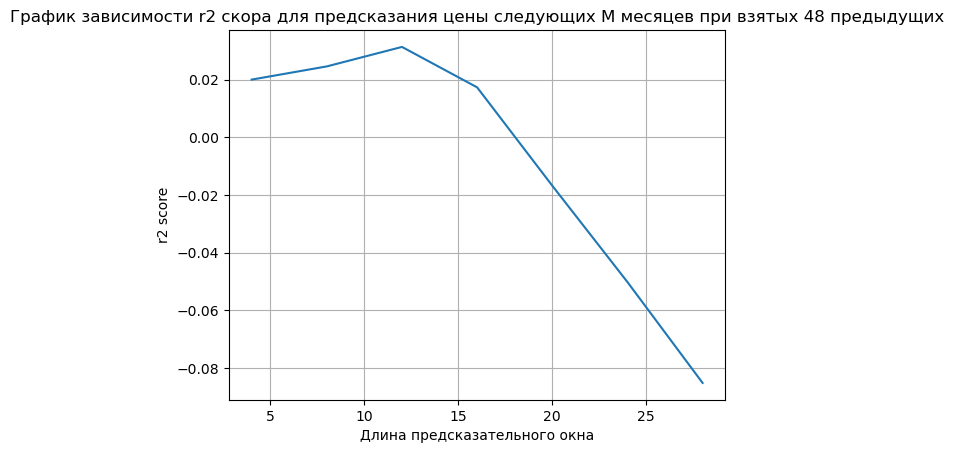

In [ ]:
import matplotlib.pyplot as plt

plt.plot(all_fut_months, result_scores)
plt.xlabel("Длина предсказательного окна")
plt.ylabel("r2 score")
plt.grid()
plt.title(
    "График зависимости r2 скора для предсказания цены следующих M месяцев при взятых 48 предыдущих"
)

Видим явный пик на 12 мес (1 год). Это нетривиальный результат, который можно частично объяснить тем, что мы оптимизировали длину памяти для фиксированной длины предсказательного окна (12 мес). 

0) Взять побольше данных.
1) Поправить все тесты (скоры) с train на test: сейчас происходит переобучение.
2) Исходя из результатов поправить выводы.
3) Попробовать перейти на более сложную модель (очень постепенно): ARIMA, MLP (1-2 слоя), возможно какая-нибудь реккурентная сеть (RNN, GRU, LSTM).
4) Попробовать добавить дополнительные фичи (волотильность (atr), объем*изменение (momentum), т.д.)

In [57]:
train_df, test_df, features, target = preprocess_monthly_stock_data(
    df, n_months=48, m_months=12, test_split_date="2022-01-01"  # Your DataFrame here
)
X, y_true = train_df[[f for f in features if "return" in f]], train_df[target]
model = LinearRegression(fit_intercept=False).fit(X, y_true)
y_pred = model.predict(X)
train_score = r2_score(y_true=y_true, y_pred=y_pred)
X, y_true = test_df[[f for f in features if "return" in f]], test_df[target]
y_pred = model.predict(X)
test_score = r2_score(y_true=y_true, y_pred=y_pred)
train_score, test_score

(0.03139232195337627, -0.9891584676567133)

In [56]:
train_df, test_df, features, target = preprocess_monthly_stock_data(
    df, n_months=48, m_months=12, test_split_date="2022-01-01"  # Your DataFrame here
)
X, y_true = train_df[features], train_df[target]
model = LinearRegression(fit_intercept=False).fit(X, y_true)
y_pred = model.predict(X)
train_score = r2_score(y_true=y_true, y_pred=y_pred)
X, y_true = test_df[features], test_df[target]
y_pred = model.predict(X)
test_score = r2_score(y_true=y_true, y_pred=y_pred)
train_score, test_score

(0.2500887713774852, -5.182678750836784)